<a href="https://colab.research.google.com/github/greyhound101/IEEE-CIS-Fraud/blob/master/simple_model_id_with_autoenc_0_917_0_88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading libraries

In [ ]:
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow as tf
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from google.colab import drive
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras import backend as K
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
import gc

In [ ]:

os.environ['KAGGLE_USERNAME'] = "tapaskd123" # username from the json file
os.environ['KAGGLE_KEY'] = "aba8dc1f085221111d925003fe5a88ed" # key from the json file
!kaggle competitions download -c ieee-fraud-detection

 96% 56.0M/58.3M [00:00<00:00, 71.1MB/s]
100% 58.3M/58.3M [00:00<00:00, 99.4MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 108MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 164MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 217MB/s]
 54% 28.0M/52.2M [00:00<00:00, 83.5MB/s]
100% 52.2M/52.2M [00:00<00:00, 132MB/s] 


loading drive

In [ ]:

drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Mounted at /content/gdrive


Loading dataframes

In [ ]:
trn=pd.read_csv('/content/gdrive/My Drive/fraud/train_id.csv',index_col=[0])
tst=pd.read_csv('/content/gdrive/My Drive/fraud/test_id.csv',index_col=[0])
trn.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,C8_std_isna,C9_std_isna,C10_std_isna,C11_std_isna,C12_std_isna,C13_std_isna,C14_std_isna,D1_mean_isna,D1_std_isna,D2_mean_isna,D2_std_isna,D3_mean_isna,D3_std_isna,D4_mean_isna,D4_std_isna,D5_mean_isna,D5_std_isna,D6_mean_isna,D6_std_isna,D7_mean_isna,D7_std_isna,D8_mean_isna,D8_std_isna,D9_mean_isna,D9_std_isna,D10_mean_isna,D10_std_isna,D11_mean_isna,D11_std_isna,D12_mean_isna,D12_std_isna,D13_mean_isna,D13_std_isna,D14_mean_isna,D14_std_isna,D15_mean_isna,D15_std_isna,V1_mean_isna,V1_std_isna,isFraud
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0


Reduce memory useage

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
trn=reduce_mem_usage(trn)
tst=reduce_mem_usage(tst)

Memory usage of dataframe is 2788.88 MB
Memory usage after optimization is: 663.99 MB
Decreased by 76.2%
Memory usage of dataframe is 2389.03 MB
Memory usage after optimization is: 566.33 MB
Decreased by 76.3%


Handling nan and inf

In [ ]:
trn=trn.replace([np.inf,-np.inf],np.nan)
tst=tst.replace([np.inf,-np.inf],np.nan)
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)

Making the callbacks and loading model

In [ ]:
dk={}
class RocCallback(Callback):
    def __init__(self,validation_data):
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.ep=0

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.ep+=1
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('roc-auc_val: %s' % str(round(roc_val,4)))

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
def load_model():
  K.clear_session()



  inp=Input((873,))
  x=Dense(256,activation=custom_gelu)(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation=custom_gelu)(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation=custom_gelu)(x)
  x=Dropout(0.3)(x)
  x=Dense(1,activation='sigmoid')(x)
  mod=Model(inputs=[inp],outputs=x)
  return mod

def custom_gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

Concatenating all data

In [ ]:
trn_s=trn.shape[0]
df=pd.concat([trn,tst],0).reset_index(drop=True)
del([trn,tst])
gc.collect()

categorical=[str(i) for i in range(444)]
df[categorical]=df[categorical].astype('uint8')

autoenc=pd.read_csv('/content/gdrive/My Drive/fraud/without_id.csv',index_col=[0])
autoenc=reduce_mem_usage(autoenc)
autoenc.columns=[i for i in range(444,444+autoenc.shape[1])]


df=pd.concat([df,autoenc],1)
del([autoenc])
gc.collect()

df=reduce_mem_usage(df)
trn=df.loc[:trn_s-1]
tst=df.loc[trn_s:].reset_index(drop=True)
del([df])
gc.collect()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Memory usage of dataframe is 2151.40 MB
Memory usage after optimization is: 544.13 MB
Decreased by 74.7%
Memory usage of dataframe is 1303.82 MB
Memory usage after optimization is: 1755.86 MB
Decreased by -34.7%


0

Reduce memory useage

In [ ]:
categorical=[str(i) for i in range(444)]
trn[categorical]=trn[categorical].astype('uint8')
tst[categorical]=tst[categorical].astype('uint8')

Fitting model

In [ ]:
ln=len(trn)/10
# tst=tst.drop(['isFraud'],1)
for i in tqdm(range(6,10)):
  X_train, X_test = trn.loc[:int(ln*i)], trn.loc[int(ln*i):]
  y_train, y_test = X_train['isFraud'], X_test['isFraud']
  X_train=X_train.drop(['isFraud'],1)
  X_test=X_test.drop(['isFraud'],1)
  mod=load_model()
  roc = RocCallback(
                  validation_data=(X_test, y_test))
  mod.compile(optimizer=Nadam(),loss='binary_crossentropy')
  es=EarlyStopping(monitor='val_loss',min_delta=0.0001,mode='min',restore_best_weights=True,patience=50)
  mod.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=2048,epochs=8,callbacks=[es,roc])
  
  del[(X_train,y_train)]
  gc.collect()

  mod.fit(X_test,y_test,epochs=2,batch_size=2048)
  if i ==6:
    pre=mod.predict(tst)/5
  else:
    pre+=mod.predict(tst)/5
  
  del([X_test,y_test,mod])
  gc.collect()


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/8
174/174 [==============================] - 11s 64ms/step - loss: 0.1138 - val_loss: 0.1866
Epoch 2/8
174/174 [==============================] - 10s 55ms/step - loss: 0.0861 - val_loss: 0.1046
Epoch 3/8
174/174 [==============================] - 10s 56ms/step - loss: 0.0773 - val_loss: 0.1030
Epoch 4/8
174/174 [==============================] - 10s 56ms/step - loss: 0.0713 - val_loss: 0.2421
Epoch 5/8
174/174 [==============================] - 10s 56ms/step - loss: 0.0698 - val_loss: 0.1209
Epoch 6/8
174/174 [==============================] - 10s 56ms/step - loss: 0.0639 - val_loss: 0.1115
Epoch 7/8
174/174 [==============================] - 10s 56ms/step - loss: 0.0588 - val_loss: 0.1317
Epoch 8/8
174/174 [==============================] - 10s 56ms/step - loss: 0.0555 - val_loss: 0.1693
Epoch 1/2
116/116 [==============================] - 1s 6ms/step - loss: 0.0880
Epoch 2/2
116/116 [==============================] - 1s 6ms/step - loss: 0.0727



 25%|██▌       | 1/4 [01:44<05:14, 104.73s/it]

Epoch 1/8
202/202 [==============================] - 9s 45ms/step - loss: 0.1094 - val_loss: 0.1170
Epoch 2/8
202/202 [==============================] - 8s 40ms/step - loss: 0.0857 - val_loss: 0.0952
Epoch 3/8
202/202 [==============================] - 8s 40ms/step - loss: 0.0773 - val_loss: 0.0914
Epoch 4/8
202/202 [==============================] - 8s 39ms/step - loss: 0.0710 - val_loss: 0.0918
Epoch 5/8
202/202 [==============================] - 8s 39ms/step - loss: 0.0652 - val_loss: 0.0934
Epoch 6/8
202/202 [==============================] - 8s 39ms/step - loss: 0.0613 - val_loss: 0.0937
Epoch 7/8
202/202 [==============================] - 8s 39ms/step - loss: 0.0571 - val_loss: 0.1038
Epoch 8/8
202/202 [==============================] - 8s 39ms/step - loss: 0.0533 - val_loss: 0.1016
Epoch 1/2
87/87 [==============================] - 1s 6ms/step - loss: 0.0803
Epoch 2/2
87/87 [==============================] - 1s 6ms/step - loss: 0.0650



 50%|█████     | 2/4 [03:16<03:21, 100.77s/it]

Epoch 1/8
231/231 [==============================] - 7s 29ms/step - loss: 0.1154 - val_loss: 0.1155
Epoch 2/8
231/231 [==============================] - 6s 25ms/step - loss: 0.0868 - val_loss: 0.1012
Epoch 3/8
231/231 [==============================] - 6s 25ms/step - loss: 0.0776 - val_loss: 0.0974
Epoch 4/8
231/231 [==============================] - 6s 25ms/step - loss: 0.0712 - val_loss: 0.1000
Epoch 5/8
231/231 [==============================] - 6s 25ms/step - loss: 0.0656 - val_loss: 0.0940
Epoch 6/8
231/231 [==============================] - 6s 25ms/step - loss: 0.0613 - val_loss: 0.0972
Epoch 7/8
231/231 [==============================] - 6s 25ms/step - loss: 0.0572 - val_loss: 0.1009
Epoch 8/8
231/231 [==============================] - 6s 25ms/step - loss: 0.0537 - val_loss: 0.0976
Epoch 1/2
58/58 [==============================] - 0s 6ms/step - loss: 0.0811
Epoch 2/2
58/58 [==============================] - 0s 6ms/step - loss: 0.0650



 75%|███████▌  | 3/4 [04:28<01:32, 92.31s/it] 

Epoch 1/8
260/260 [==============================] - 5s 17ms/step - loss: 0.1145 - val_loss: 0.1060
Epoch 2/8
260/260 [==============================] - 4s 15ms/step - loss: 0.0856 - val_loss: 0.0982
Epoch 3/8
260/260 [==============================] - 4s 15ms/step - loss: 0.0769 - val_loss: 0.0943
Epoch 4/8
260/260 [==============================] - 4s 15ms/step - loss: 0.0699 - val_loss: 0.0966
Epoch 5/8
260/260 [==============================] - 4s 15ms/step - loss: 0.0648 - val_loss: 0.0931
Epoch 6/8
260/260 [==============================] - 4s 15ms/step - loss: 0.0607 - val_loss: 0.0915
Epoch 7/8
260/260 [==============================] - 4s 15ms/step - loss: 0.0569 - val_loss: 0.0952
Epoch 8/8
260/260 [==============================] - 4s 15ms/step - loss: 0.0533 - val_loss: 0.0956
Epoch 1/2
29/29 [==============================] - 0s 6ms/step - loss: 0.0832
Epoch 2/2
29/29 [==============================] - 0s 6ms/step - loss: 0.0654



100%|██████████| 4/4 [05:25<00:00, 81.30s/it]


In [ ]:
sub=pd.read_csv('sample_submission.csv.zip')
sub['isFraud']=pre
sub=sub.set_index('TransactionID')
sub.to_csv('sub.csv')
sub.head()

,isFraud
TransactionID,
3663549,0.000041
3663550,0.000007
3663551,0.004497
3663552,0.000536
3663553,0.000002


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


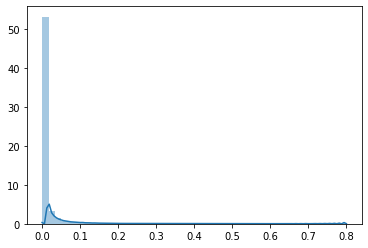

In [ ]:
import seaborn as sns
sns.distplot(pre)